# Detectron2


In [1]:
from wholeslidedata.interoperability.detectron2.iterator import WholeSlideDetectron2Iterator
from wholeslidedata.interoperability.detectron2.trainer import WholeSlideDectectron2Trainer
from wholeslidedata.interoperability.detectron2.predictor import Detectron2DetectionPredictor
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch, plot_batch_detection
import argparse
import os
from pathlib import Path


from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model

import time
from matplotlib import pyplot as plt
from wholeslidedata.visualization.plotting import plot_boxes
import numpy as np

In [2]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigerdetectiondata.yml",
            'labels': {
                "roi": 0,
                "lymphocytes and plasma cells": 1
            },
            
            "annotation_parser": {
                "sample_label_names": ['roi']
            },
            'batch_shape': {
                'batch_size': 10,
                'spacing': 0.55,
                'shape': [64,64,3],
                'y_shape': [1000, 6],
            },
            
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -32},
            },
            
            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 1000,
                "detection_labels": ['lymphocytes and plasma cells'],
            },
            
        }
    }
}
output_folder = Path('/home/user/detectron2_trained')
cpus = 4

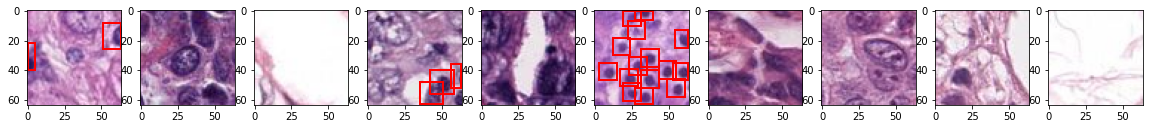

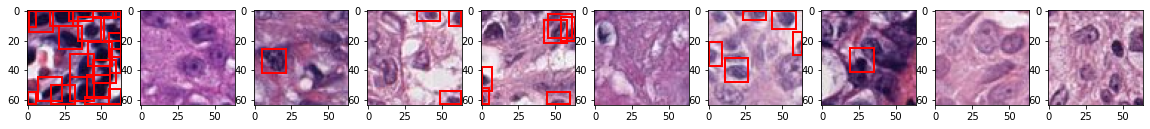

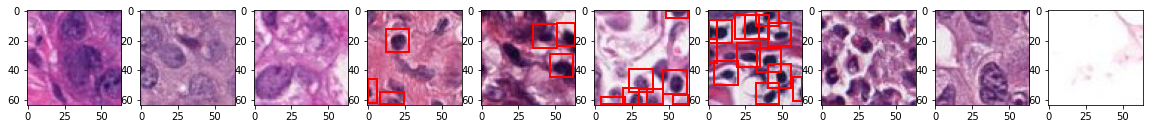

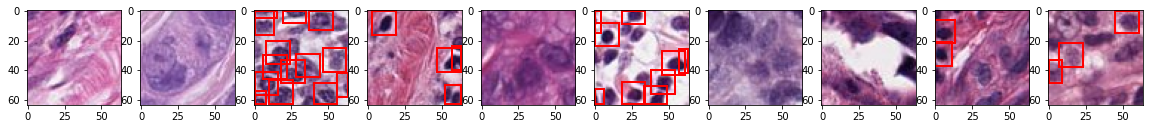

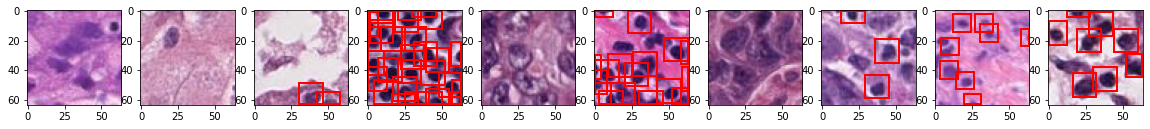

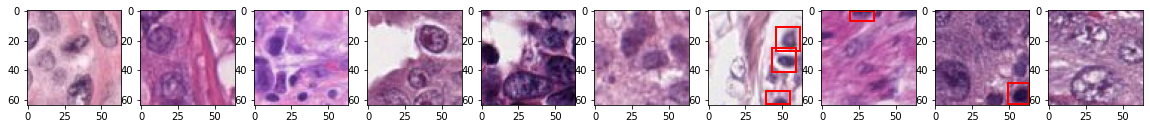

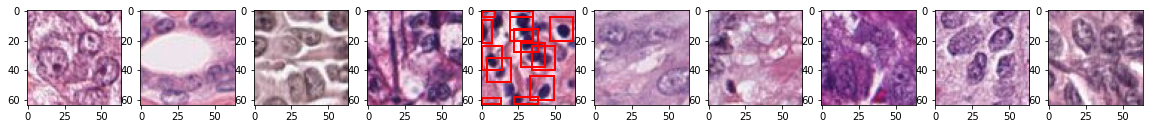

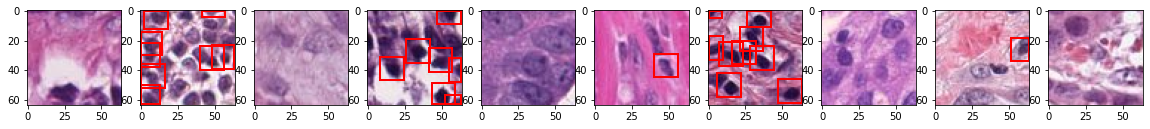

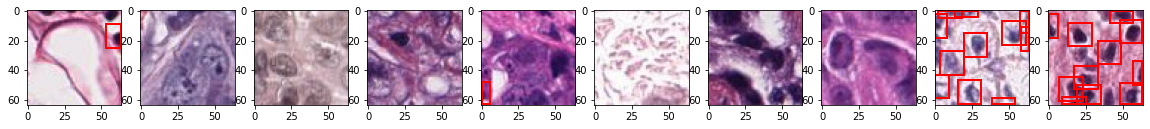

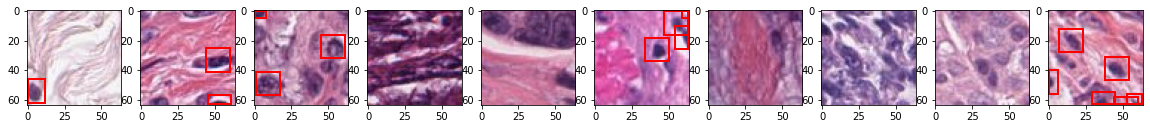

In [3]:
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
    iterator_class=WholeSlideDetectron2Iterator,
) as training_batch_generator:
    for _ in range(10):
        batch_dicts = next(training_batch_generator)
        fig, ax = plt.subplots(1,10, figsize=(20,10))
        for i in range(10):
            patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1,2,0).astype('uint8')
            _boxes =  batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
            boxes = np.ones((len(_boxes), 6))
            boxes[..., :4] = _boxes
            max_width, max_height = batch_dicts[i]['instances'].image_size
            ax[i].imshow(patch)
            plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[i])
        plt.show()

In [8]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (10, 100, 250)
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = None

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

trainer = WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)
trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
41080371
[01/29 18:33:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
  

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[01/29 18:33:35 d2.engine.train_loop]: Starting training from iteration 0
[01/29 18:34:00 d2.utils.events]:  eta: 0:05:43  iter: 19  total_loss: 0.8492  loss_cls: 0.1674  loss_box_reg: 0.1302  loss_rpn_cls: 0.5453  loss_rpn_loc: 0.02679  time: 0.1724  data_time: 1.0846  lr: 0.0005  max_mem: 1899M
[01/29 18:34:04 d2.utils.events]:  eta: 0:05:44  iter: 39  total_loss: 0.6633  loss_cls: 0.164  loss_box_reg: 0.1862  loss_rpn_cls: 0.2398  loss_rpn_loc: 0.02393  time: 0.1793  data_time: 0.0022  lr: 0.0005  max_mem: 1899M
[01/29 18:34:07 d2.utils.events]:  eta: 0:05:41  iter: 59  total_loss: 0.5028  loss_cls: 0.1697  loss_box_reg: 0.1719  loss_rpn_cls: 0.1309  loss_rpn_loc: 0.02424  time: 0.1806  data_time: 0.0020  lr: 0.0005  max_mem: 1899M
[01/29 18:34:11 d2.utils.events]:  eta: 0:05:34  iter: 79  total_loss: 0.391  loss_cls: 0.126  loss_box_reg: 0.1444  loss_rpn_cls: 0.09956  loss_rpn_loc: 0.02374  time: 0.1786  data_time: 0.0018  lr: 0.0005  max_mem: 1899M
[01/29 18:34:14 d2.utils.events]

In [9]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "/home/user/detectron2_trained/model_final.pth"

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Parameter Count:
41080371


In [10]:
predictor = Detectron2DetectionPredictor(cfg)
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
) as training_batch_generator:
    
    batch_x, batch_y, info = next(training_batch_generator)
    batch_x, batch_y, info = next(training_batch_generator)
    predicted_batch = predictor.predict_on_batch(batch_x)

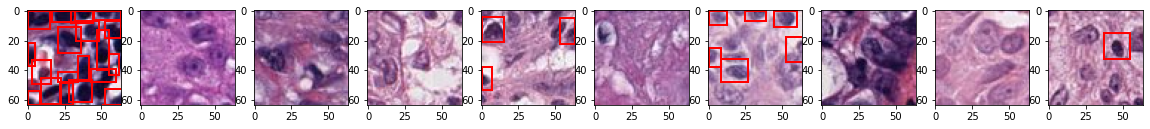

In [11]:

fig, ax = plt.subplots(1,10, figsize=(20,10))
for i in range(10):
    patch = batch_x[i]
    boxes =  predicted_batch[i]['boxes']
    confidences = predicted_batch[i]['confidences']
    filtered_boxes = []
    for box, confidence in zip(boxes, confidences):
        if confidence > 0.3:
            filtered_boxes.append(box)
    ax[i].imshow(patch)
    plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[i])
plt.show()